In [1]:
import pandas as pd
import seaborn as sns
import gzip
import nltk
from nltk.corpus import stopwords
import warnings; warnings.simplefilter('ignore')
import os, codecs, string, random
import numpy as np
from numpy.random import seed as random_seed
from numpy.random import shuffle as random_shuffle
import matplotlib.pyplot as plt
%matplotlib inline  

seed = 42
random.seed(seed)
np.random.seed(seed)

#NLP libraries
import spacy, nltk, gensim, sklearn
#import pyLDAvis.gensim
import pyLDAvis.gensim_models

#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Scikit imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from scipy import sparse as sp
# from textblob import TextBlob

/Users/jehandebryas/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [2]:
# import small train and test datasets
train_neg = [tweet[:-1] for tweet in open('./twitter-datasets/train_neg.txt').readlines()]
train_pos = [tweet[:-1] for tweet in open('./twitter-datasets/train_pos.txt').readlines()]
test_data = [tweet[:-1] for tweet in open('./twitter-datasets/test_data.txt').readlines()]

# import vocab_cut
vocab = [word[:-1] for word in open('./vocab_cut.txt').readlines()]

In [11]:
X, y = train_neg + train_pos, [-1 for i in range(len(train_neg))]+[1 for i in range(len(train_pos))]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
count_vect = CountVectorizer(vocabulary = vocab)
X_train_counts = count_vect.fit_transform(X_train)
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.shape

(180000, 101298)

### Try PCA because dimension is very high

In [4]:
clf = TruncatedSVD(100)
Xpca = clf.fit_transform(X_train_tf)
pca = PCA(n_components=30).fit_transform(X = Xpca)

In [5]:
pca.shape

(180000, 30)

<AxesSubplot:>

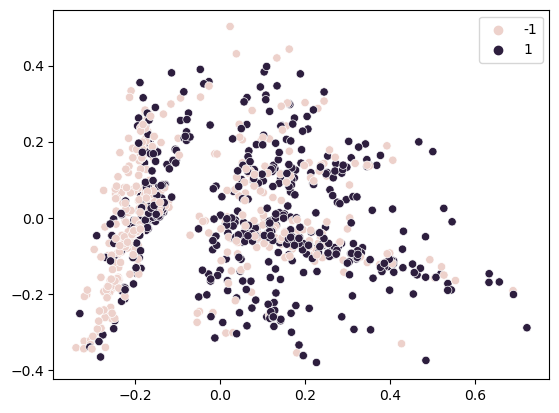

In [42]:
sns.scatterplot(x = pca[:1000,0], y = pca[:1000,1], hue = y_train[:1000])

## Pipeline using logistic regression

In [20]:
pipl = Pipeline([
    ('vect', CountVectorizer(vocabulary = vocab, ngram_range = (1, 5))),
    ('tfidf', TfidfTransformer()),
    ('logreg', LogisticRegression()),
])

In [21]:
X, y = train_neg + train_pos, [-1 for i in range(len(train_neg))]+[1 for i in range(len(train_pos))]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
pipl.fit(X_train, y_train)
prediction = pipl.predict(X_test)
print('accuracy = {}'.format(accuracy_score(y_test, prediction)))

accuracy = 0.81385


In [ ]:
# create a submission to AIcrowd
df = pd.DataFrame.from_dict({'Id' : range(1, 10001), 'Prediction': prediction.tolist()})
df.to_csv('submission1.csv', index=False)

## Pipeline using decision tree classifier

In [43]:
pipl = Pipeline([
    ('vect', CountVectorizer(vocabulary = vocab, ngram_range = (1, 3))),
    ('clf', DecisionTreeClassifier(max_depth=50)),
])

In [44]:
X, y = train_neg + train_pos, [-1 for i in range(len(train_neg))]+[1 for i in range(len(train_pos))]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
pipl.fit(X_train, y_train)
prediction = pipl.predict(X_test)
print('accuracy = {}'.format(accuracy_score(y_test, prediction)))

accuracy = 0.756


## Pipeline using neural networks

In [39]:
pipl = Pipeline([
    ('vect', CountVectorizer(vocabulary = vocab, ngram_range = (1, 3))),
    ('tfidf', TfidfTransformer()),
    ('mlp', MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(20, 10, 10, 10, 10), random_state=4, activation = 'relu')),
])

In [40]:
X, y = train_neg + train_pos, [-1 for i in range(len(train_neg))]+[1 for i in range(len(train_pos))]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipl.fit(X_train, y_train)
prediction = pipl.predict(X_test)
print('accuracy = {}'.format(accuracy_score(y_test, prediction)))

0.807125